In [ ]:
#This plot1 is for display the site distribution and climate change pattern across the sites

In [5]:
#import sys
#sys.executable

In [1]:
import os
from osgeo import osr, gdal
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rasterio
from rasterio.plot import plotting_extent
#from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib import pyplot
import matplotlib.colors as colors
from mycolorpy import colorlist as mcp
from matplotlib.gridspec import GridSpec
from scipy.interpolate import make_interp_spline
from matplotlib.lines import Line2D
%matplotlib inline

In [2]:
data_dir="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\0_Adaptation\\2_Data\\"
gis="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\0_Adaptation\\2_Data\\gisData\\"
fig_dir="E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\0_Adaptation\\6_Plots\\"

In [195]:
#Process weather - don't need to rerun it again. 
pd.options.mode.chained_assignment = None #ignore the warming
wea_dir="E:\\Works\\IWIN\\climate\\"
#1a - Changes in growing-season Tavg across nursery sites
#ax1=fig.add_subplot(2,2,1)
#Only Tavg
ssp=['126','370','585']
nursery=['ESWYT','HTWYT','IDYN','SAWYT','IWWYT_IRR','IWWYT_SA']
#clim='tavg'#['tavg','tdr','gdd30','rs','p','rh','vpd','ws','co2']
for n in range(len(nursery)):
    df=pd.read_csv(wea_dir+nursery[n]+".csv")
    #calculate the mean for projected historical climate - 1981-2010
    his=df[df.sce.isin(['gf_h','ip_h','mk_h','mp_h','mr_h'])]
    his=his[(his.year>1980) & (his.year<2011)]
    his=his.iloc[:,1:].groupby(by=['loc','sce']).mean().reset_index()
    his['sce1']=[x[:2] for x in his['sce']]
    his=his[['loc','sce1','tavg','rs','gdd30','p']]
    #Future
    fut=df[df.sce.isin(list(set(df.sce.unique().tolist())-set(['ar_h','gf_h','ip_h','mk_h','mp_h','mr_h'])))]
    fut['sce1']=fut.sce.str[:2]
    fut=fut[['year','tavg','rs','gdd30','p','sce','loc','sce1']]
    fut=fut.merge(his,on=['loc','sce1'],how='inner')
    fut['tavg']=fut['tavg_x']-fut['tavg_y']  #absolute change in Tavg
    fut['gdd30']=fut['gdd30_x']-fut['gdd30_y']
    fut['rs']=100*(fut['rs_x']-fut['rs_y'])/fut['rs_y']  #percentage change in sr
    fut['p']=100*(fut['p_x']-fut['p_y'])/fut['p_y']  #percentage change in p
    #fut['gdd30']=fut['gdd30_y']  #take log value we can see the expoential change of GEE corresponding to tavg
    fut['ssp']=fut.sce.str[3:]
    fut=fut[['year','ssp','loc','tavg','rs','gdd30','p']]
    fut['nursery']=nursery[n]
    if n==0:
        out=fut
    else:
        out=pd.concat([out,fut],axis=0)
out.to_csv(data_dir+"ChangeInClimate.csv",index=False)

In [3]:
#colors for each nursery
colors=mcp.gen_color('Paired',n=6)  #Six color corresponds to each trial
color=['purple','blue','green','red','grey','pink']  #Set pre-defined color
nursery=['ESWYT', 'IDYN', 'IWWYT_IRR','HTWYT', 'SAWYT', 'IWWYT_SA']
d = dict([(y,x+1) for x,y in enumerate(sorted(set(nursery)))])
out=pd.read_csv(data_dir+"ChangeInClimate.csv")

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_20212\2204064873.py:6: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  out=pd.read_csv(data_dir+"ChangeInClimate.csv")


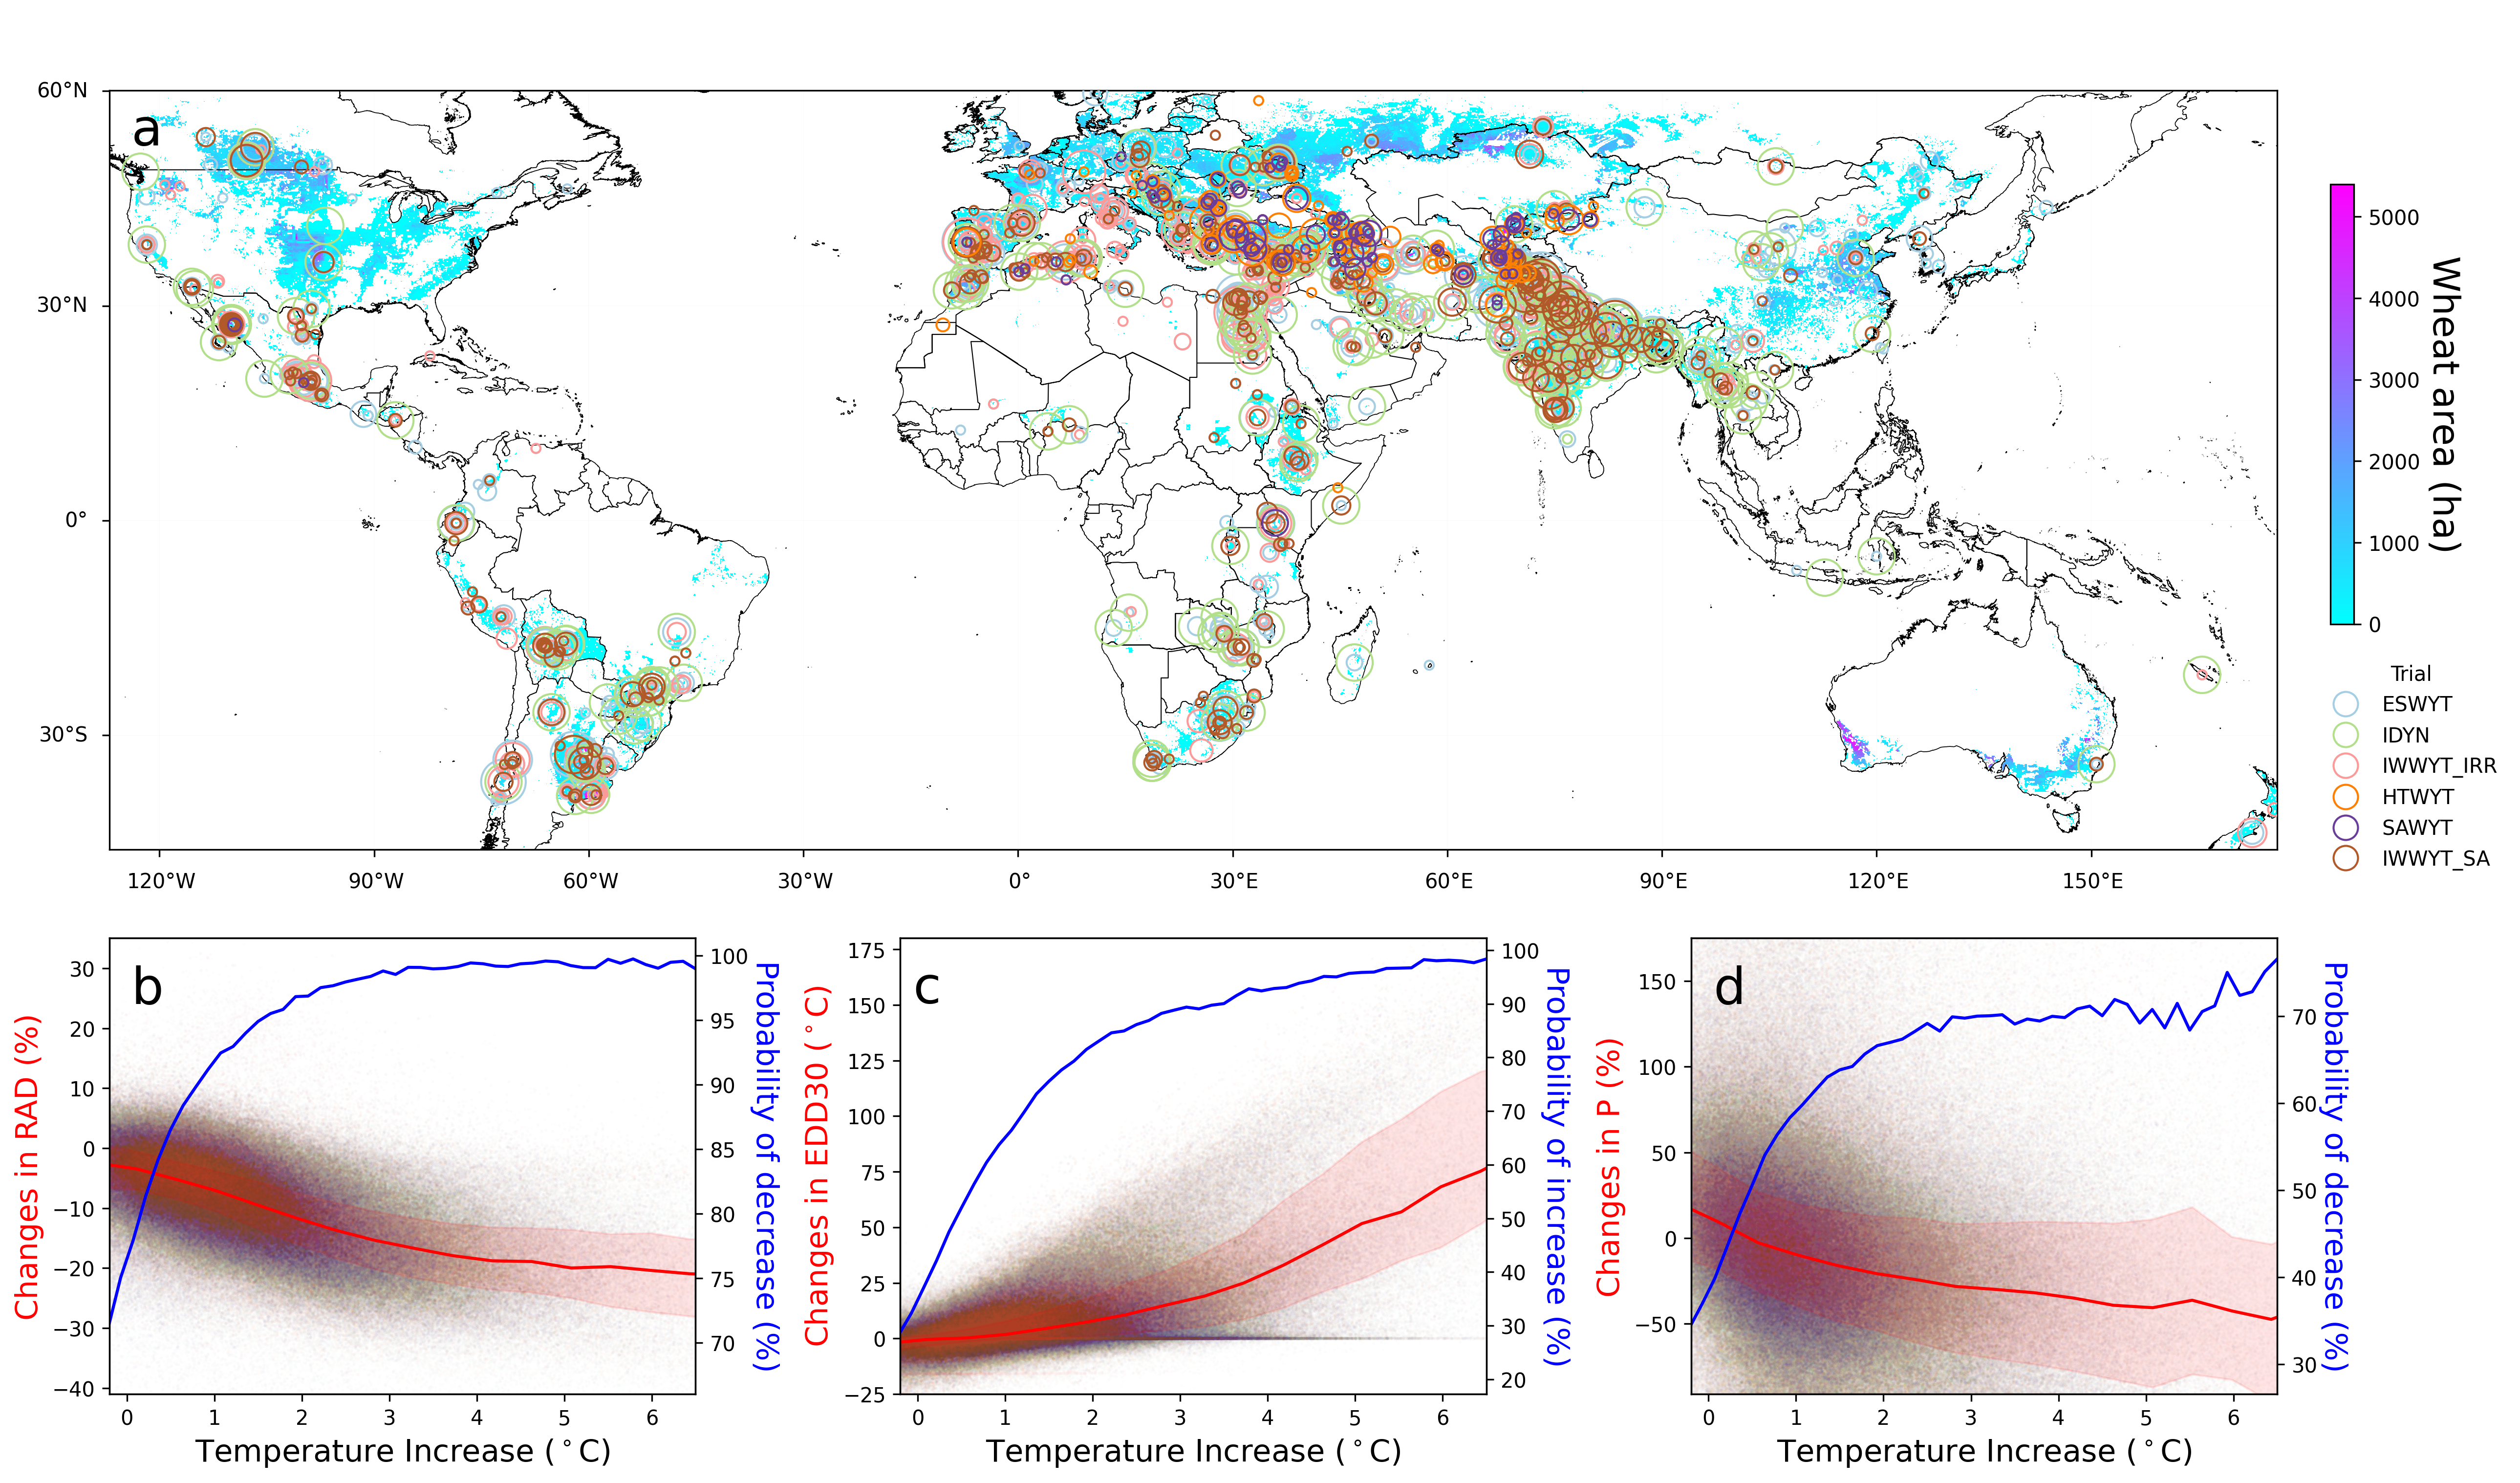

In [4]:
#site distribution
fig=plt.figure(constrained_layout=True,figsize=(16,10),dpi=300)
gs=GridSpec(3,3,figure=fig,hspace=0,wspace=0.01)
#Site distribution and global wheat areas
ax = fig.add_subplot(gs[0:2,:],)
site=pd.read_csv(data_dir+"AllTrailSite.csv")
lat=site['lat'].values
lon=site['lon'].values
lat_min,lat_max,lon_min,lon_max = -46,60,-127,176
lat_ticks=np.arange(-30,65,30)
lon_ticks=np.arange(-120,180,30)
extent=(lon_min,lon_max,lat_min,lat_max)

raster=rasterio.open(gis+"SPAMwheatArea_Clip1.tif")
extent=plotting_extent(raster)  #####
array=raster.read(1)
#remove nodata cells
array=np.ma.masked_where(array<1,array,copy=True)
chm_plot=ax.imshow(array,cmap='cool',vmin=0,vmax=5400,extent=extent,resample=True,interpolation='bilinear',
                  aspect='auto')
#colorbar=fig.colorbar(chm_plot,ax=ax,extend='both',shrink=0.8,pad=0.01)
#colorbar.ax.set_ylabel('Wheat area (ha)', rotation=270,labelpad=20,fontdict={'fontsize':15})
m=Basemap(resolution='l',ax=ax,
        llcrnrlat=extent[2],urcrnrlat=extent[3],
        llcrnrlon=extent[0],urcrnrlon=extent[1])
#m.drawcoastlines(linewidth=0.5)
#m.readshapefile('E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\0_Adaptation\\2_Data\\gisDataRegions\\Regions',name='counties',linewidth=0.2)
#m.drawcountries(linewidth=0.5) #,color='grey'
os.chdir("E:\\Dropbox (RSG)\\Works\\CurrentProcessing\\Wheat_Phenotypic\\0_Adaptation\\2_Data\\gisData")
m.readshapefile('Regions',name='counties',linewidth=0.4,color='k')

m.drawcountries(linewidth=0.5,color='k') #,color='grey'
#m.drawmapboundary(fill_color='aqua',zorder=0)
#m.fillcontinents(color='white',lake_color='aqua',alpha=1)
#m.drawmapboundary(fill_color='#46bcec')
#m.fillcontinents(color = 'white',lake_color='#46bcec')
#Trial site - plot points as red dots
lons, lats = m(lon, lat)
ax.scatter(lons, lats, marker = 'o', c='none',zorder=5, s=[20*x for x in site.trail.tolist()],
           edgecolor=[colors[x-1] for x in [d[x] for x in site.nursery.tolist()]],#conver all site to color
           linewidth=1) #[10*x for x in site.trail.tolist()]cmap='tab10',
# convert from degree to map projection
lon_ticks_proj, _=m(lon_ticks, np.zeros(len(lon_ticks)))
_, lat_ticks_proj=m(np.zeros(len(lat_ticks)), lat_ticks)
# manually add ticks
ax.set_xticks(lon_ticks_proj)
ax.set_yticks(lat_ticks_proj)
ax.tick_params(axis='both',which='major')
# remove the tick labels
ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
m.drawparallels(lat_ticks,labels=[1,0,0,0],linewidth=0.01,xoffset=3,) # need to enlarge the offset a bit
m.drawmeridians(lon_ticks,labels=[0,0,0,1],linewidth=0.01,yoffset=3) # need to enlarge the offset a bit
###########################Subplot for climate########################################################
color_map={'ESWYT':colors[0],'IDYN':colors[1],'IWWYT_IRR':colors[2],
           'HTWYT':colors[3],'SAWYT':colors[4],'IWWYT_SA':colors[5]}
climate_color=['red','blue']
fonts=15
#out=pd.read_csv(data_dir+"ChangeInClimate.csv")
var=['rs','gdd30','p']
ylim=[[-41,35],[-25,180],[-91,175]]
ytitle=['Changes in RAD (%)','Changes in EDD30 ($^\circ$C)', 'Changes in P (%)']
y2title=['Probability of decrease (%)','Probability of increase (%)','Probability of decrease (%)']
for i in range(3):
    ax=fig.add_subplot(gs[2:,i])
    df=out[['nursery','tavg',var[i]]]
    df=df[~df.isin([np.nan, np.inf, -np.inf])]#.any(1)] #remove nan cell and infinite cells
    ax.scatter(df['tavg'],df[var[i]],c=df['nursery'].map(color_map),s=1,alpha=0.01,marker='.')
    df=df.iloc[:,1:]
    df.tavg=df.tavg.round(1)  #Median of change for each 0.1C
    temp=df.groupby(by='tavg').median().reset_index() #Median
    x=np.array(temp.tavg)
    y=np.array(temp[var[i]])
    X_Y_Spline=make_interp_spline(x,y)  #Smooth the line
    X_=np.linspace(x.min(),x.max(),50)
    Y_=X_Y_Spline(X_)
    ax.plot(X_,Y_,c=climate_color[0])
    X_Y_Spline=make_interp_spline(x,np.array(df.groupby(by='tavg').quantile(0.25).reset_index()[var[i]]))
    Y_lower=Y_=X_Y_Spline(X_)
    X_Y_Spline=make_interp_spline(x,np.array(df.groupby(by='tavg').quantile(0.75).reset_index()[var[i]]))
    Y_up=Y_=X_Y_Spline(X_)
    ax.fill_between(X_,Y_lower,Y_up,color=climate_color[0],alpha=0.1)
    #Possibility 
    ax1=ax.twinx()
    temp=df.groupby(by='tavg').count().reset_index()
    if i==1: #EDD increase
        temp1=df[df[var[i]]>0][['tavg',var[i]]].groupby(by='tavg').count().reset_index()
    else:
        temp1=df[df[var[i]]<0][['tavg',var[i]]].groupby(by='tavg').count().reset_index() 
    temp=temp.merge(temp1,on='tavg')
    temp['derspossible']=100*(temp[var[i]+'_y']/temp[var[i]+'_x'])
    x=np.array(temp.tavg)  
    y=np.array(temp.derspossible)
    X_Y_Spline=make_interp_spline(x,y) #Smooth the line
    X_=np.linspace(-0.5,6.5,50) #Only look at the range of temperature increase untill 6.5C
    Y_=X_Y_Spline(X_)
    ax1.plot(X_,Y_,c=climate_color[1])
    ax.set_xlabel('Temperature Increase ($^\circ$C)',fontsize=fonts)
    ax.set_ylabel(ytitle[i],color=climate_color[0],fontsize=fonts)
    ax1.set_ylabel(y2title[i],color=climate_color[1],rotation=270,labelpad=15,fontsize=fonts)
    ax.set_ylim(ylim[i])
    ax.set_xlim([-0.2,6.5])
###Legend
#fig.subplots_adjust(right=0.8)
cbar_ax=fig.add_axes([0.99,0.58,0.01,0.30])
colorbar=fig.colorbar(chm_plot,cax=cbar_ax)#extend='both',
colorbar.ax.set_ylabel('Wheat area (ha)', rotation=270,labelpad=20,fontdict={'fontsize':18})
legend=[]
for i in range(6):
    legend=legend+[Line2D([0],[0],markeredgecolor=colors[i],markerfacecolor='white',marker='o',markersize=12,linestyle='None')]
cbar_ax.legend(legend,nursery,bbox_to_anchor=(7.9,-.05),frameon=False)
cbar_ax.get_legend().set_title('Trial')
ax=fig.add_subplot(111, frameon=False)
ax.text(0.05,0.91,'a',fontsize=25)
ax.text(0.05,0.32,'b',fontsize=25)
ax.text(0.385,0.32,'c',fontsize=25)
ax.text(0.728,0.32,'d',fontsize=25)
ax.tick_params(left=False,bottom=False,labelleft=False,labelbottom=False)
#fig.tight_layout()
fig.savefig(fig_dir+'Plot1_Climate_4N.png',dpi=300,bbox_inches="tight")

In [5]:
#fig.savefig(fig_dir+'Plot1_Climate.png',dpi=300)
fig.savefig(fig_dir+'Plot1_Climate_4N.png',dpi=300,bbox_inches="tight")